## About the project
[UBC's SkySpark IoT platform](https://skyspark.energy.ubc.ca), managed by UBC Energy and Water Services (EWS), collects data on weather and UBC buildings every 15 minutes. The Urban Data Lab (UDL) is streaming the SkySpark data into an InfluxDB instance to increase its accessibility and usability.

Public users (read permissions only) can log in to our **InfluxDB 2.0 User Interface** http://206.12.92.81:8086/ with the following credentials
- Username:`public02`
- Password:`public02`

Public users can also use this authorization token `omUybYZ3QkGvuXXy0VwT-7hoO2SEFzhckXJ5k32K_GvG47yHQAi9JzZ1bii6r1HD5NKux3ZhHlKAyUfj6i61bA==`

to access this InfluxDB database from [InfluxDB command line interface](https://docs.influxdata.com/influxdb/v2.0/) or [InfluxDB API client libraries](https://docs.influxdata.com/influxdb/v2.0/tools/client-libraries/). 

This tutorial demonstrates querying the InfluxDB database using the `influxdb-client` Python module. Please [contact UDL](https://urbandatalab.io/) if you have any questions.

## Dependecies

```python
# -----------------------------------------------
# SKYSPARK 2.0 Tutorial v1
# Author: Jiachen Wei, UBC Urban Data Lab
# Date: Mar 2021
# Python version: 3.8.5
# -----------------------------------------------

#influxdb-client for InfluxDB 2.x and InfluxDB 1.8+
# More information https://pypi.org/project/influxdb-client/
! pip install influxdb-client
```

In [1]:
import pandas as pd
import influxdb_client
from datetime import timezone, datetime
import pytz
import matplotlib.pyplot as plt
%matplotlib inline

## Connecting and Querying UDL's InfluxDB

In [2]:
#Define a few variables with the name of your bucket, organization, and token.
bucket = "SKYSPARK"
org = "UBC"
#UDL provides public users READ access to the InfluxDB 2.0 instance via this token
token = "omUybYZ3QkGvuXXy0VwT-7hoO2SEFzhckXJ5k32K_GvG47yHQAi9JzZ1bii6r1HD5NKux3ZhHlKAyUfj6i61bA=="
url="http://206.12.92.81:8086/"

In [3]:
#Instantiate the client.
client = influxdb_client.InfluxDBClient(url=url, token=token, org=org)

#Create a Flux query.
    #Flux documentation https://docs.influxdata.com/influxdb/v2.0/reference/flux/
    #You can generate Flux query using the Query Builder on http://206.12.92.81:8086/
#Let's query the data on chillers in the Pharmacy building for July 2020
query = '''from(bucket: "SKYSPARK")
  |> range(start: 2020-07-01T00:00:00Z, stop: 2020-07-31T23:59:59Z)
  |> filter(fn: (r) => r["_measurement"] == "READINGS")
  |> filter(fn: (r) => r["siteRef"] == "Pharmacy")
  |> filter(fn: (r) => r["uniqueID"] == "r:p:ubcv:r:21432e1c-45d33081 Pharmacy Cooling Plant CH-1 CHLR1_COP" or r["uniqueID"] == "r:p:ubcv:r:21433651-788ebe09 Pharmacy Cooling Plant CH-2 CHLR2_COP" or r["uniqueID"] == "r:p:ubcv:r:21433667-2be787b5 Pharmacy Cooling Plant CH-3 CHLR3_COP" or r["uniqueID"] == "r:p:ubcv:r:21433683-704eac70 Pharmacy Cooling Plant CH-4 CHLR4_COP")
  |> filter(fn: (r) => r["_field"] == "val_num")'''

##Instantiate the query client. Specify org and query.
result = client.query_api().query_data_frame(org=org, query=query)

In [4]:
pd.options.display.max_rows = 5
pd.options.display.max_columns = None
result

,result,table,_start,_stop,_time,_value,_field,_measurement,equipRef,groupRef,navName,siteRef,typeRef,uniqueID,unit
0,_result,0,2020-07-01 00:00:00+00:00,2020-07-31 23:59:59+00:00,2020-07-01 00:00:00+00:00,3.797291,val_num,READINGS,Cooling Plant CH-1,Pharmacy Hydronic Systems,cop,Pharmacy,CHLR1_COP,r:p:ubcv:r:21432e1c-45d33081 Pharmacy Cooling ...,_
1,_result,0,2020-07-01 00:00:00+00:00,2020-07-31 23:59:59+00:00,2020-07-01 00:10:00+00:00,4.521705,val_num,READINGS,Cooling Plant CH-1,Pharmacy Hydronic Systems,cop,Pharmacy,CHLR1_COP,r:p:ubcv:r:21432e1c-45d33081 Pharmacy Cooling ...,_
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17826,_result,3,2020-07-01 00:00:00+00:00,2020-07-31 23:59:59+00:00,2020-07-31 23:40:00+00:00,0.000000,val_num,READINGS,Cooling Plant CH-4,Pharmacy Hydronic Systems,cop,Pharmacy,CHLR4_COP,r:p:ubcv:r:21433683-704eac70 Pharmacy Cooling ...,_
17827,_result,3,2020-07-01 00:00:00+00:00,2020-07-31 23:59:59+00:00,2020-07-31 23:50:00+00:00,0.000000,val_num,READINGS,Cooling Plant CH-4,Pharmacy Hydronic Systems,cop,Pharmacy,CHLR4_COP,r:p:ubcv:r:21433683-704eac70 Pharmacy Cooling ...,_


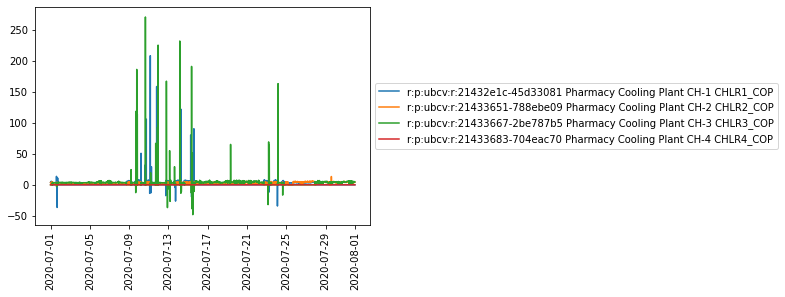

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
for uid,dfm in result.groupby('uniqueID'):
    ax.plot(dfm['_time'],dfm['_value'],label=uid)
    # Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation='vertical')
plt.show()